In [25]:
!pip install -U finance-datareader
!pip install torch torchvision

Requirement already up-to-date: finance-datareader in /usr/local/lib/python3.6/dist-packages (0.9.6)


In [0]:
import FinanceDataReader as fdr
import datetime
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
import argparse
import time
from copy import deepcopy # Add Deepcopy for args
from sklearn.metrics import mean_absolute_error
import FinanceDataReader as fdr

In [0]:
%matplotlib inline
#데이터 생성과 화면 표시를 위한 라이브러리 호출
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
    

In [28]:
'''import FinanceDataReader as fdr

# 한국거래소 상장종목 전체
df_krx = fdr.StockListing('KRX')
df_krx.head()'''

"import FinanceDataReader as fdr\n\n# 한국거래소 상장종목 전체\ndf_krx = fdr.StockListing('KRX')\ndf_krx.head()"

In [0]:
class StockDataset(Dataset):
    
    def __init__(self, symbol, x_frames, y_frames, start, end):
        
        self.symbol = symbol
        self.x_frames = x_frames
        self.y_frames = y_frames
        
        self.start = datetime.datetime(*start)
        self.end = datetime.datetime(*end)

        self.data = fdr.DataReader(self.symbol, self.start, self.end)
        print(self.data.isna().sum())
        
    def __len__(self):
        return len(self.data) - (self.x_frames + self.y_frames) + 1
    
    def __getitem__(self, idx):
        idx += self.x_frames
        data = self.data.iloc[idx-self.x_frames:idx+self.y_frames]
        data = data[['High', 'Low', 'Open', 'Close', 'Change', 'Volume']]
        data = data.apply(lambda x: np.log(x+1) - np.log(x[self.x_frames-1]+1))
        data = data.values
        X = data[:self.x_frames]
        y = data[self.x_frames:]
        
        return X, y

In [0]:
class StockDataset2(Dataset):
    
    def __init__(self, symbol, x_frames, y_frames, start, end):
        
        self.symbol = symbol
        self.x_frames = x_frames
        self.y_frames = y_frames
        
        self.start = datetime.datetime(*start)
        self.end = datetime.datetime(*end)

        self.data = fdr.DataReader(self.symbol, self.start, self.end)
        print(self.data.isna().sum())
        
    def __len__(self):
        return len(self.data) - (self.x_frames + self.y_frames) + 1

    def __getitem__(self, idx):
        idx += self.x_frames
        data = self.data.iloc[idx-self.x_frames:idx+self.y_frames]
        data = data[['High', 'Low', 'Open', 'Close', 'Change', 'Volume']]
        
        #data = data.apply(lambda x: np.log(x+1) - np.log(x[self.x_frames-1]+1))
        data = data.values
        X = data[:self.x_frames]
        y = data[self.x_frames:]
        
        return X, y

In [0]:
class LSTM(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, batch_size, dropout, use_bn):
        super(LSTM, self).__init__()
        self.input_dim = input_dim 
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        self.batch_size = batch_size
        self.dropout = dropout
        self.use_bn = use_bn 
        
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        self.hidden = self.init_hidden()
        self.regressor = self.make_regressor()
        
    def init_hidden(self):
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
    
    def make_regressor(self):
        layers = []
        if self.use_bn:
            layers.append(nn.BatchNorm1d(self.hidden_dim))
        layers.append(nn.Dropout(self.dropout))
        
        layers.append(nn.Linear(self.hidden_dim, self.hidden_dim // 2))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(self.hidden_dim // 2, self.output_dim))
        regressor = nn.Sequential(*layers)
        return regressor
    
    def forward(self, x):
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        y_pred = self.regressor(lstm_out[-1].view(self.batch_size, -1))
        return y_pred

In [0]:
def metric(y_pred, y_true):
    perc_y_pred = np.exp(y_pred.cpu().detach().numpy())
    perc_y_true = np.exp(y_true.cpu().detach().numpy())
    mae = mean_absolute_error(perc_y_true, perc_y_pred, multioutput='raw_values')
    return mae*100

In [0]:
def train(model, partition, optimizer, loss_fn, args):
    trainloader = DataLoader(partition['train'], 
                             batch_size=args.batch_size, 
                             shuffle=True, drop_last=True)
    model.train()
    model.zero_grad()
    optimizer.zero_grad()

    train_acc = 0.0
    train_loss = 0.0
    for i, (X, y) in enumerate(trainloader):

        X = X.transpose(0, 1).float().to(args.device)
        y_true = y[:, :, 3].float().to(args.device)
        #print(torch.max(X[:, :, 3]), torch.max(y_true))

        model.zero_grad()
        optimizer.zero_grad()
        model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

        y_pred = model(X)
        loss = loss_fn(y_pred.view(-1), y_true.view(-1))
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += metric(y_pred, y_true)[0]

    train_loss = train_loss / len(trainloader)
    train_acc = train_acc / len(trainloader)
    return model, train_loss, train_acc

In [0]:
def validate(model, partition, loss_fn, args):
    valloader = DataLoader(partition['val'], 
                           batch_size=args.batch_size, 
                           shuffle=False, drop_last=True)
    model.eval()

    val_acc = 0.0
    val_loss = 0.0
    with torch.no_grad():
        for i, (X, y) in enumerate(valloader):

            X = X.transpose(0, 1).float().to(args.device)
            y_true = y[:, :, 3].float().to(args.device)
            model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

            y_pred = model(X)
            loss = loss_fn(y_pred.view(-1), y_true.view(-1))

            val_loss += loss.item()
            val_acc += metric(y_pred, y_true)[0]

    val_loss = val_loss / len(valloader)
    val_acc = val_acc / len(valloader)
    return val_loss, val_acc

In [0]:
def test(model, partition, args):
    testloader = DataLoader(partition['test'], 
                           batch_size=args.batch_size, 
                           shuffle=False, drop_last=True)
    model.eval()

    test_acc = 0.0
    with torch.no_grad():
        for i, (X, y) in enumerate(testloader):

            X = X.transpose(0, 1).float().to(args.device)
            y_true = y[:, :, 3].float().to(args.device)
            model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

            y_pred = model(X)
            test_acc += metric(y_pred, y_true)[0]

    test_acc = test_acc / len(testloader)
    return test_acc

In [0]:
def experiment(partition, model, args):

    model.to(args.device)
    loss_fn = torch.nn.MSELoss()

    loss_fn = nn.MSELoss()
    if args.optim == 'SGD':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    # ===== List for epoch-wise data ====== #
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    # ===================================== #
        
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        model, train_loss, train_acc = train(model, partition, optimizer, loss_fn, args)
        val_loss, val_acc = validate(model, partition, loss_fn, args)
        te = time.time()
        
        # ====== Add Epoch Data ====== #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        # ============================ #
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.5f}/{:2.5f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
        
    test_acc = test(model, partition, args)    
    
    # ======= Add Result to Dictionary ======= #
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result

In [0]:
# ====== Random Seed Initialization ====== #
seed = 666
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ====== Data Loading ====== #
args.symbol = '028050'
args.batch_size = 100
args.x_frames = 5
args.y_frames = 5



In [38]:
trainset = StockDataset(args.symbol, args.x_frames, args.y_frames, (2000,1,1), (2016,1,1))
valset = StockDataset(args.symbol, args.x_frames, args.y_frames, (2016,1,1), (2018,1,1))
testset = StockDataset(args.symbol, args.x_frames, args.y_frames, (2018,1,1), (2019,2,1))
partition = {'train': trainset, 'val':valset, 'test':testset}

Open      0
High      0
Low       0
Close     0
Volume    0
Change    0
dtype: int64
Open      0
High      0
Low       0
Close     0
Volume    0
Change    0
dtype: int64
Open      0
High      0
Low       0
Close     0
Volume    0
Change    0
dtype: int64


In [39]:

# ====== Model Capacity ===== #
args.input_dim = 6
args.hid_dim = 50
args.n_layers = 2

# ====== Regularization ======= #
args.l2 = 0.00001
args.dropout = 0.6
args.use_bn = True

# ====== Optimizer & Training ====== #
args.optim = 'Adam' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0001
args.epoch = 50


# ====== Experiment Variable ====== #
name_var1 = 'lr'
name_var2 = 'n_layers'
var1 = 0.0001
var2 = 3

model = LSTM(args.input_dim, args.hid_dim, args.y_frames, args.n_layers, args.batch_size, args.dropout, args.use_bn)


setattr(args, name_var1, var1)
setattr(args, name_var2, var2)
print(args)
        
setting, result = experiment(partition, model,deepcopy(args))

Namespace(batch_size=100, device='cuda', dropout=0.6, epoch=50, hid_dim=50, input_dim=6, l2=1e-05, lr=0.0001, n_layers=3, optim='Adam', symbol='028050', use_bn=True, x_frames=5, y_frames=5)
Epoch 0, Acc(train/val): 21.14/14.11, Loss(train/val) 0.05632/0.02128. Took 23.04 sec
Epoch 1, Acc(train/val): 15.90/12.51, Loss(train/val) 0.03490/0.01996. Took 23.10 sec
Epoch 2, Acc(train/val): 13.26/9.07, Loss(train/val) 0.02487/0.05122. Took 22.93 sec
Epoch 3, Acc(train/val): 11.72/8.58, Loss(train/val) 0.01930/0.06117. Took 23.10 sec
Epoch 4, Acc(train/val): 10.58/7.21, Loss(train/val) 0.01624/0.06197. Took 23.20 sec
Epoch 5, Acc(train/val): 9.62/7.24, Loss(train/val) 0.01384/0.06184. Took 22.99 sec
Epoch 6, Acc(train/val): 8.89/5.77, Loss(train/val) 0.01201/0.06477. Took 23.15 sec
Epoch 7, Acc(train/val): 8.28/5.80, Loss(train/val) 0.01083/0.06759. Took 23.21 sec
Epoch 8, Acc(train/val): 7.56/5.38, Loss(train/val) 0.00944/0.07060. Took 23.31 sec
Epoch 9, Acc(train/val): 7.00/5.28, Loss(train/

In [40]:
k = fdr.DataReader('068270')
k.tail(10)

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2020-05-27,212000,214000,211000,213000,591712,-0.006993
2020-05-28,212500,213500,206000,211000,716459,-0.009390
2020-05-29,212000,214000,209500,213500,660343,0.011848
2020-06-01,214000,232500,213000,227500,3410255,0.065574
2020-06-02,230000,232500,222000,224500,1115810,-0.013187
2020-06-03,231500,235000,224500,227500,1813508,0.013363
2020-06-04,227500,248000,227000,247000,3037387,0.085714
2020-06-05,244000,260500,243000,256500,2899453,0.038462
2020-06-08,260500,263000,253000,256000,1267019,-0.001949


In [41]:
testinput = StockDataset('068270',5,5,(2019,1,1),(2020,5,13))
ts = StockDataset2('068270',5,5,(2019,1,1),(2020,5,13))
testloader = DataLoader(testinput, batch_size=100, shuffle=False, drop_last=True)
tt = DataLoader(ts, batch_size=100, shuffle=False, drop_last=True)

print(len(testloader))

Open      0
High      0
Low       0
Close     0
Volume    0
Change    0
dtype: int64
Open      0
High      0
Low       0
Close     0
Volume    0
Change    0
dtype: int64
3


In [0]:

result = []

for i, (X,y) in enumerate(testloader):

    model.eval()
    X = X.transpose(0, 1).float().to(args.device)
    y_true = y[:, :, 3].float().to(args.device)
    model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

    y_pred = model(X)
    y_pred = y_pred.view(-1)
    y_true = y_true.view(-1)
    y_pred = np.exp(y_pred.cpu().detach().numpy())
    y_true = np.exp(y_true.cpu().detach().numpy())
    result.append(y_pred/y_true)


In [0]:
result2 = []
for X,y in tt:
    y_true = y[:, :, 3].float()
    y_true = y_true.view(-1)
    y_true = y_true.cpu().detach().numpy()
    result2.append(y_true)

In [0]:
t = []
for i in result:
    for j in i:
        t.append(j)
z = []
for i in result2:
    for j in i:
        z.append(j)

for i in range(len(t)):
    t[i] = t[i] * z[i]

In [45]:
print(z)
print(t)

[204401.0, 206789.0, 206789.0, 201536.0, 198193.0, 206789.0, 206789.0, 201536.0, 198193.0, 192939.0, 206789.0, 201536.0, 198193.0, 192939.0, 186731.0, 201536.0, 198193.0, 192939.0, 186731.0, 191984.0, 198193.0, 192939.0, 186731.0, 191984.0, 189119.0, 192939.0, 186731.0, 191984.0, 189119.0, 191029.0, 186731.0, 191984.0, 189119.0, 191029.0, 191029.0, 191984.0, 189119.0, 191029.0, 191029.0, 198670.0, 189119.0, 191029.0, 191029.0, 198670.0, 199148.0, 191029.0, 191029.0, 198670.0, 199148.0, 201536.0, 191029.0, 198670.0, 199148.0, 201536.0, 201058.0, 198670.0, 199148.0, 201536.0, 201058.0, 205356.0, 199148.0, 201536.0, 201058.0, 205356.0, 209177.0, 201536.0, 201058.0, 205356.0, 209177.0, 204879.0, 201058.0, 205356.0, 209177.0, 204879.0, 204401.0, 205356.0, 209177.0, 204879.0, 204401.0, 205356.0, 209177.0, 204879.0, 204401.0, 205356.0, 205834.0, 204879.0, 204401.0, 205356.0, 205834.0, 202968.0, 204401.0, 205356.0, 205834.0, 202968.0, 202491.0, 205356.0, 205834.0, 202968.0, 202491.0, 200580.0,

Text(0.5, 1.0, 'pred vs real')

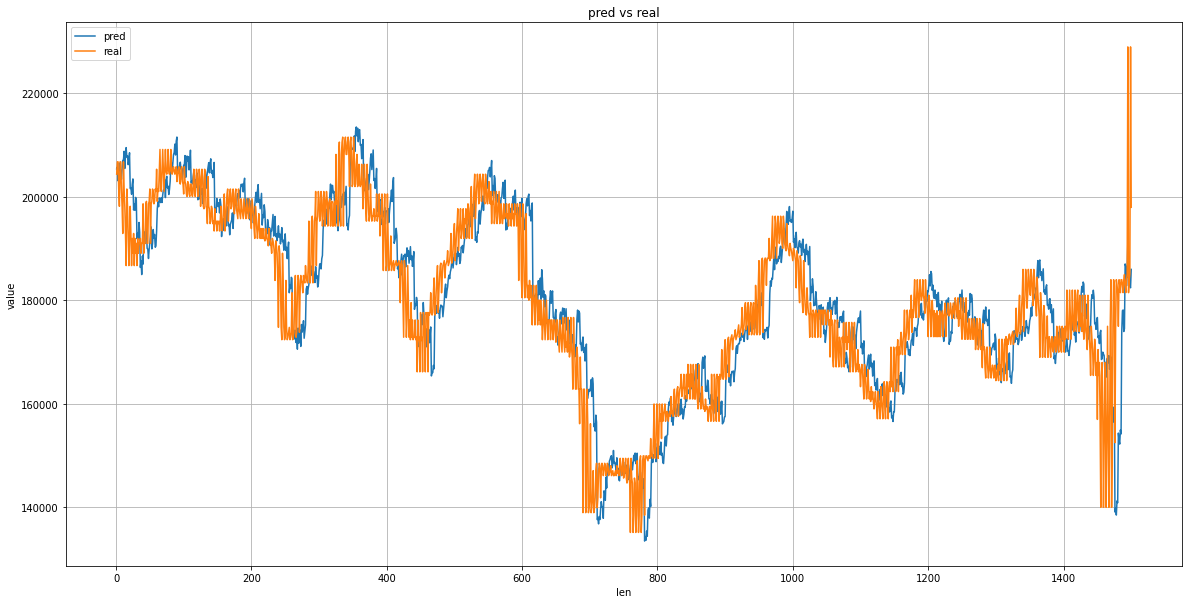

In [46]:
fig = plt.figure(figsize=(20,10))
xl = [n for n in range(1,len(t)+1)]


# ====== test plot ====== #
ax = fig.add_subplot(1, 1, 1)
ax.plot(xl, t,  label='pred')
ax.plot(xl, z,  label='real')
ax.set_xlabel('len')
ax.set_ylabel('value')
ax.grid()
ax.legend()
ax.set_title('pred vs real')

In [47]:
from google.colab import drive
drive.mount('/content/gdrive')

modelPath = '/content/gdrive/My Drive/LSTM_batch_100_model.pt'
torch.save(model.state_dict(), modelPath)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
